In [22]:
## libraries
import sys
import datacube

# plotting
from matplotlib import pyplot as plt
# maths
import numpy as np
# save png images
import imageio
import csv

import utilities

## GLOBALS
# sentinel Analysis Ready Data
sentinel_product = "s2a_ard_granule"
sentinel_bands = ['nbart_red', 'nbart_green', 'nbart_blue']
# landsat granule
landsat_product = "ga_ls8c_ard_3"
landsat_bands = ['nbart_red', 'nbart_green', 'nbart_blue']

# how many white or black squares before we flag and remove?
# 5%
flag_pct = .05

In [17]:
dc = datacube.Datacube(app="super_res_examples")

In [52]:
## Products available?
dc = datacube.Datacube(app='dc-FC')
products = dc.list_products()
print(products.keys())
display_columns = ['name', 'description','time','resolution']
display_rows = [1]
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("ls")]

Index(['name', 'description', 'gqa_iterative_mean_x', 'gqa_ref_source',
       'fmask_water', 'dataset_maturity', 'fmask_snow',
       'gqa_abs_iterative_mean_y', 'gqa_mean_x', 'gqa_error_message', 'time',
       'gqa_abs_y', 'gqa_stddev_y', 'eo_sun_azimuth',
       'gqa_abs_iterative_mean_xy', 'gqa', 'landsat_product_id',
       'gqa_iterative_stddev_y', 'gqa_iterative_mean_y', 'label', 'gqa_cep90',
       'instrument', 'gqa_iterative_stddev_x', 'gqa_mean_xy', 'product_family',
       'gqa_stddev_x', 'gqa_final_gcp_count', 'gqa_iterative_mean_xy',
       'gqa_iterative_stddev_xy', 'format', 'gqa_mean_y', 'fmask_cloud_shadow',
       'creation_time', 'region_code', 'gqa_abs_xy', 'gqa_final_qa_count',
       'gqa_stddev_xy', 'eo_gsd', 'fmask_clear', 'product_type',
       'eo_sun_elevation', 'platform', 'lon', 'lat', 'gqa_abs_x',
       'gqa_abs_iterative_mean_x', 'landsat_scene_id', 'cloud_cover', 'crs',
       'resolution', 'tile_size', 'spatial_dimensions'],
      dtype='object')


,name,description,time,resolution
id,,,,
70,ga_ls5t_ard_3,"Landsat 5 TM ARD, GA Collection 3",None,NaN
71,ga_ls7e_ard_3,"Landsat 7 ETM+ ARD, GA Collection 3",None,NaN
72,ga_ls8c_ard_3,"Landsat 8 OLI-TIRS ARD, GA Collection 3",None,NaN
51,ls5_ard,Landsat 5 ARD datasets for the GA/USGS interop...,None,NaN
4,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",None,"(-25, 25)"
48,ls5_level1_usgs,Landsat 5 USGS Level 1 Collection-1 OLI-TIRS,None,NaN
3,ls5_nbart_geomedian_annual,"Surface Reflectance Geometric Median 25 metre,...",None,"(-25, 25)"
59,ls5_nbart_tmad_annual,Surface Reflectance Triple Median Absolute Dev...,None,"(-25, 25)"
60,ls5_pq_albers,"Landsat 5 Pixel Quality 25 metre, 100km tile, ...",None,"(-25, 25)"


In [38]:

query = {
    "x": (134,134.1),
    "y": (-30.,-30.1),
    "time": "2017",
    "output_crs": "EPSG:3577",
    "resolution": (-25, 25),
    #"group_by": "solar_day",
}

## download ard granule
ds = dc.load(
    product=landsat_product,
    #measurements = sentinel_bands,
    **query
)
    
print(ds)

<xarray.Dataset>
Dimensions:                     (time: 23, x: 389, y: 455)
Coordinates:
  * time                        (time) datetime64[ns] 2017-01-05T00:57:16.971593 ... 2017-12-23T00:57:16.708309
  * y                           (y) float64 -3.265e+06 -3.265e+06 ... -3.276e+06
  * x                           (x) float64 1.906e+05 1.907e+05 ... 2.003e+05
Data variables:
    nbar_coastal_aerosol        (time, y, x) int16 374 361 360 ... 377 379 372
    nbar_blue                   (time, y, x) int16 442 436 435 ... 463 456 450
    nbar_green                  (time, y, x) int16 781 786 776 ... 722 733 731
    nbar_red                    (time, y, x) int16 1509 1591 1558 ... 1337 1338
    nbar_nir                    (time, y, x) int16 2123 2165 2146 ... 1934 1949
    nbar_swir_1                 (time, y, x) int16 3286 3388 3350 ... 2876 2938
    nbar_swir_2                 (time, y, x) int16 2827 2946 2880 ... 2634 2690
    nbar_panchromatic           (time, y, x) int16 1075 1082 1095 .

(455, 389) <class 'xarray.core.dataarray.DataArray'>
INFO: shape, type:  (455, 389, 3) <class 'numpy.ndarray'>
INFO: min, max:  13 242
1 white flag


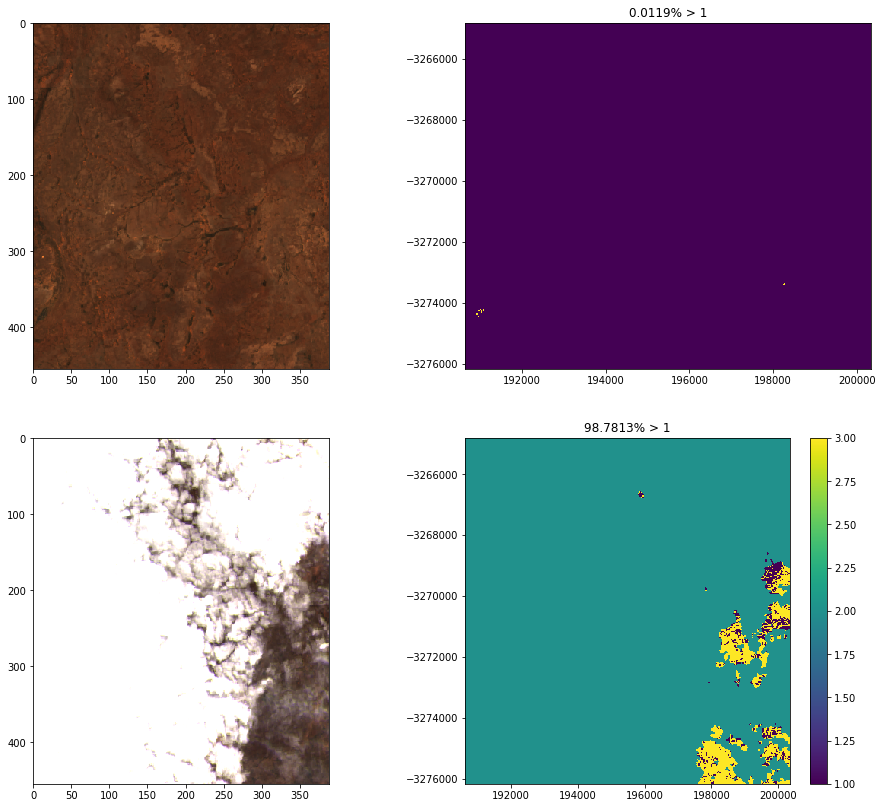

In [48]:

tind = 7
img1 = np.moveaxis(ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=tind).to_array().values,0,2)
img2 = np.moveaxis(ds[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=tind+1).to_array().values,0,2)
lons=ds.x.values
lats=ds.y.values
## clouds: 
# fmask = 2 implies shadow
# fmask = 3 implies cloud
cloud1 = ds['oa_fmask'].isel(time=tind)
cloud2 = ds['oa_fmask'].isel(time=tind+1)
print(cloud1.shape,type(cloud1))

## Normalise image into uint
img1 = utilities.jesse_normalise(img1)
img2 = utilities.jesse_normalise(img2)

print("INFO: shape, type: ",img.shape, type(img1))
print("INFO: min, max: ", np.min(img1), np.max(img1))

for i,img in enumerate([img1,img2]):
    if np.sum(img==0) > flag_pct*np.size(img):
        print(i,"black flag")
    if np.sum(img==255) > flag_pct*np.size(img):
        print(i,"white flag")

plt.figure(figsize=[16,14])
plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.pcolormesh(lons,lats,cloud1)
plt.title("%.4f%% > 1"%(100*float(np.sum(cloud1>1))/np.size(cloud1)))
plt.subplot(223)
plt.imshow(img2)
plt.subplot(224)
plt.pcolormesh(lons,lats,cloud2)
plt.title("%.4f%% > 1"%(100*float(np.sum(cloud2>1))/np.size(cloud2)))
plt.colorbar()
#f,axes = utilities.compare_two_images(img1,img2)

#plt.sca(axes[0])

#plt.sca(axes[1])
#plt.title("")
## Save figure
#fname="test_images/ls_.png"%flag
#imageio.imwrite(fname,img)
#print("INFO: Saved figure: ",fname)


(171, 171, 3)
<class 'numpy.ndarray'>
<PIL.Image.Image image mode=RGB size=400x400 at 0x7F9EDED38C50>


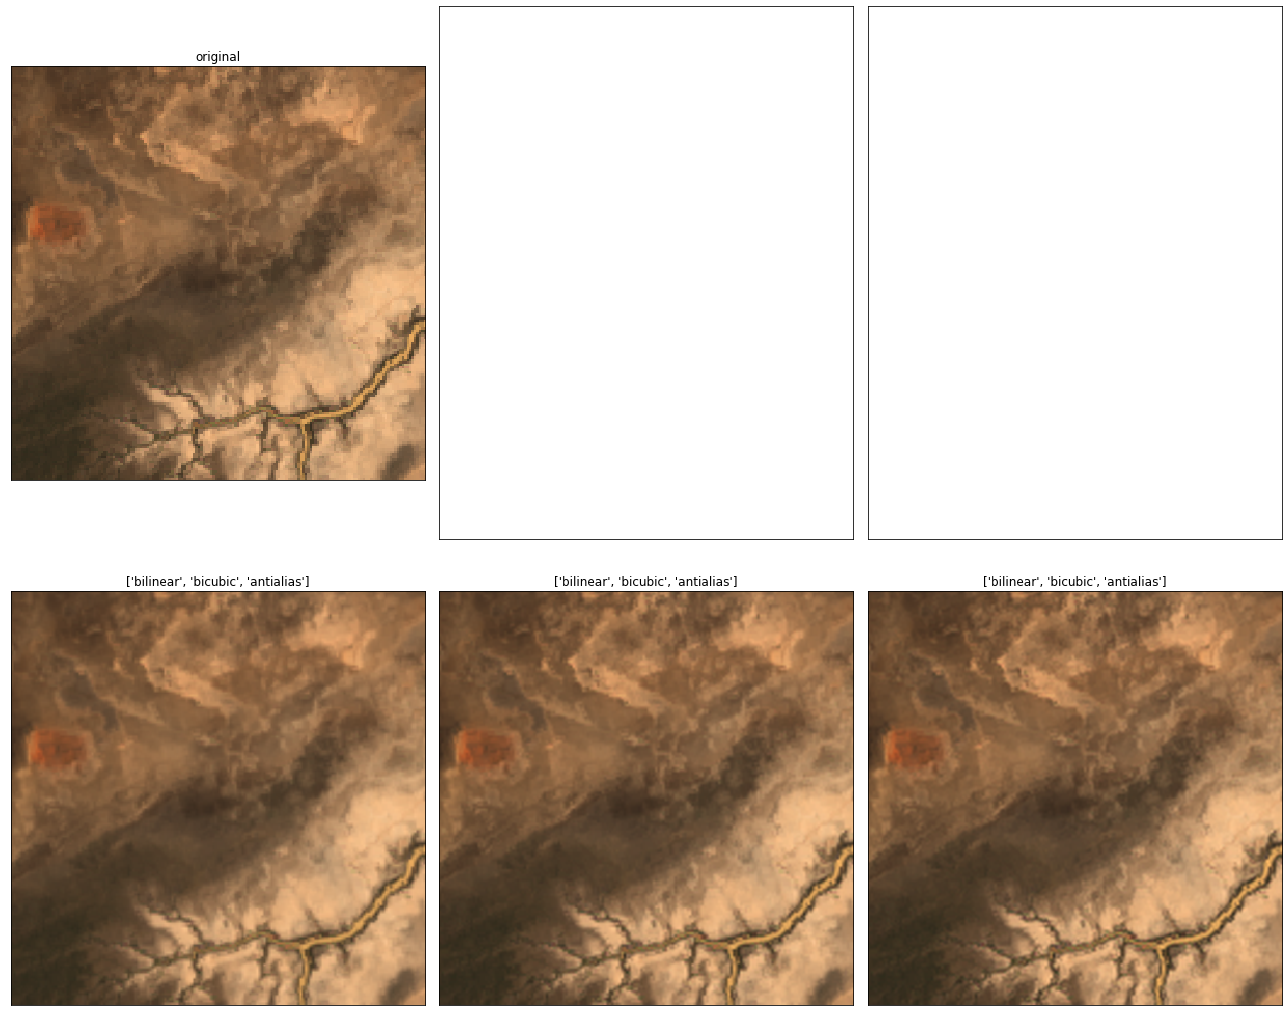

In [75]:

from PIL import Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def imresize(img,res,interp):
    
    img1pil=Image.fromarray(img)
    return img1pil.resize(res, interp)

interp = Image.BILINEAR


## Read image to PIL class
## 
LS8_ORIG = "batch4/0095_landsat_02.png"
LS8_SUPER = "batch4_hr/xxx.png"
SEN_ORIG = "batch4/xxxxx_kkk_mm.png"

orig = imageio.imread(LS8_ORIG).__array__()
#supe = mpimg.imread(LS8_SUPER)
#sen = mpimg.imread(SEN_ORIG)
print(orig.shape)
print(type(orig))

# get interpolations to compare
bil = imresize(orig,(400,400),Image.BILINEAR)
cub = imresize(orig,(400,400),Image.BICUBIC)
ant = imresize(orig,(400,400),Image.ANTIALIAS)

f,axes = plt.subplots(2,3,figsize=[18,15])

for i,img in enumerate([orig,]):
    plt.sca(axes[0,i])
    plt.imshow(img)
    plt.title(["original","super","sentinel"][i])
for i,img in enumerate([bil,cub,ant]):
    plt.sca(axes[1,i])
    plt.imshow(img)
    plt.title(["bilinear","bicubic","antialias"])
    
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
plt.tight_layout()


# could use ANTIALIAS, BICUBIC, NEAREST, BILINEAR

print(im_resized)    


In [68]:
type(orig.__array__())

numpy.ndarray

In [76]:
from glob import glob
### Make comparison over time at collie

LS5_ORIG = "batch5/2001*.png"
LS5_SUPER = "collie_landsat_hr/*.png"

SEN_ORIG = "batch5/2002*.png"

ls5o_files = glob(LS5_ORIG)
ls5s_files = glob(LS5_SUPER)
sen_files = glob(SEN_ORIG)

for i,ls5o, ls5s in enumerate(zip(ls5o_files,ls5s_files)):
    
    orig = imageio.imread(ls5o).__array__()
    supe = imageio.imread(ls5s).__array__()
    # #sen = mpimg.imread(SEN_ORIG)
    print(orig.shape)
    print(type(orig))

    f,axes = plt.subplots(2,1,figsize=[18,15])

# for i,img in enumerate([orig,]):
#     plt.sca(axes[0,i])
#     plt.imshow(img)
#     plt.title(["original","super","sentinel"][i])
# for i,img in enumerate([bil,cub,ant]):
#     plt.sca(axes[1,i])
#     plt.imshow(img)
#     plt.title(["bilinear","bicubic","antialias"])
    
# for ax in axes.flatten():
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels("")
#     ax.set_yticklabels("")
# plt.tight_layout()

254
254
123
